<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_noisereduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup

!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum

# helper functions 
def interferringTone(x,fs,freq=2000,level_dB = 65):
    A = utils.from_dB(level_dB)
    xlen = np.max(x.shape)
    
    x_sin = A * np.sin(2*np.pi*freq * np.arange(xlen)/fs)
    
    return x_sin

def interferringNoise(x,fs,SNR = 10):
    x_noise = np.random.randn(*x.shape)
    x_noise, _ = utils.adjustSNR(x,x_noise,SNR)
    
    return x_noise

fatal: destination path 'SRP2021' already exists and is not an empty directory.


# Del 3: Støjreduktion

I forrige øvelse så vi at støjfyldte signaler kan behandles i tids-frekvens domænet, og på den måde forbedre et ønsket signal. I bedste tilfælde kunne støjen fjernes fuldstændigt uden at det ønskede signal blev forringet. I virkelige scenarier er det dog sjældent at almindelige filtre kan benyttes til at fjerne støj. Dette vil vi undersøge i denne del af øvelsen.




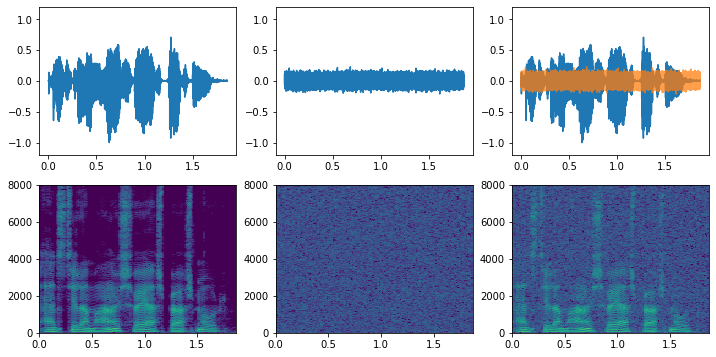

In [15]:
#@title Eksempel på støj i talesignal
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if f.endswith('.wav')]))


x, fs = utils.getAudio(audioDir+audioFiles[-1])
x = processing.normalize().transform(x)

x_noise = interferringNoise(x,fs,SNR=10)
x_m = x+x_noise

maxval = np.max(np.abs(x))

stft = spectrum.STFT(fs=fs,nperseg=2048,nfft=2)
Xm = stft.transform(x_m)
X = stft.transform(x)
Xn = stft.transform(x_noise)

display(utils.play(x,fs))
display(utils.play(x_noise,fs))
display(utils.play(x_m,fs))


plt.figure(figsize=(12,6))

#plot tale
plt.subplot(231)
t = np.arange(len(x.T))/fs
plt.plot(t,x.T/maxval)
plt.ylim([-1.2,1.2])

plt.subplot(234)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(X[0])),vmin=0,vmax=90)
plt.ylim([0,8000])

#plot noise
plt.subplot(232)
plt.plot(t,x_noise.T/maxval)
plt.ylim([-1.2,1.2])

plt.subplot(235)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xn[0])),vmin=0,vmax=90)
plt.ylim([0,8000])

#plot mix
plt.subplot(233)
plt.plot(t,x.T/maxval)
plt.plot(t,x_noise.T/maxval,alpha=0.75)
plt.ylim([-1.2,1.2])

plt.subplot(236)
plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Xm[0])),vmin=0,vmax=90)
plt.ylim([0,8000])



plt.show()

* Beskriv hvordan signalet oven for lyder, og hvad forskellen er fra denne type støj og de eksempler vi arbejdede med i forrige øvelse.
* Hvordan kan støjen ses i spektrogrammet?

* Hvorfor kan lavpas- højpas- eller båndstop-filtre ikke bruges til at fjerne netop denne type støj?



# Måling af signal-støj forhold

Signal-støjforhold (engelsk: signal-to-noise ratio, forkortet SNR) er en værdi som udtrykker lydstyrken af signalet i forhold til lydstyrken af støjen. 
I dette afsnit vil vi se på målemetoder til at bestemme signal styrken på digitale signaler, samt beregne signal støjforhold.


## Root mean square
Signal styrken kan måles i root-mean-square (forkortet: RMS). Metoden virker ved at tage kvadratroden af middelværdien af signalet i anden potens. Matematisk kan de skrives som i formlen nedenfor:

$x_{RMS} = \sqrt{\dfrac{1}{N}\sum_{n=0}^{N} x^2[n]}$,

Hvor $N$ er antallet af samples i signalet $x$. 

**Eksempel:**

Vi ønsker at beregne RMS værdien for et signal bestående af 8 elementer $x[n] = [0,1,0,-1,0,1,0,-1]$.
1. Signalet opløftes i anden potens: $x^2[n] =  [0,1,0,1,0,1,0,1]$
2. Middelværdien beregnes $\dfrac{1}{N} \sum_{n=0}^{N} x^2[n] = \dfrac{1}{8}(0+1+0+1+0+1+0+1)  = 0.5 $
3. Kvadratroden berenges, $x_{RMS} = \sqrt{0.5} \simeq 0.707$

RMS kan fortolkes som den gennemsnitlige amplitude af et vilkårligt signal.

## Signal-to-noise ratio

Signal støj forholdet kan beregnes hvis RMS værdien for signalet og støjen kendes. 

$SNR = \big(\dfrac{A_s}{A_n}\big)^2$,

hvor $A_s$ er RMS amplituden for signalet, og $A_n$ er RMS amplituden for støjen. Da RMS udtrykkes i effekt og ikke i amplitude, opløftes forholdet i anden potens.




In [75]:
#* todo: Make a widget where they can play around with signal levels before they start working with thresholding. I would like for them to get a feeling and a mathematical understanding of the dB scale. They should begin with listening to signals at different levels and get a feeling for how much a difference in lets say 3dB, 6dB, 12dB and 24dB is.
#  * Questions for them: Why use a logarithmic scale?

#* todo: Next part should be SNR. Instead of listening to the same sound at different levels, they should listening to a speech signal in noise, where the SNR changes. They should be able to compute the SNR in dB given the energy of the speech and noise after this exercise.
#  * Again: Why use a log scale for SNR? 

a = np.random.randn(1)*1000
b = np.random.randn(1)*1000

c = a**2/b**2
print(c)

print((a/b)**2)

[4.43537067]
[4.43537067]


# Støjreduktion
Hvis man undersøger spektrogrammet ses det at lydniveauet af talesignalet er højere end lydniveauet af baggrundsstøjen. Denne information kan benyttes til at designe et filter der fjerner lave lyde og bevarer høje lyde. 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


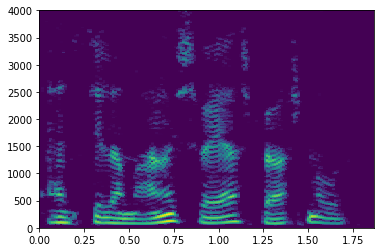

In [ ]:
#@title processing {run : "auto"}
threshold = 33 #@param {type:"slider"}

XmLevel = 20*np.log10(np.abs(Xm))

mask = XmLevel > threshold


Ym = (mask * np.abs(Xm)) * np.exp(1j*np.angle(Xm))
plt.pcolormesh(stft.t,stft.f,mask[0])

plt.pcolormesh(stft.t,stft.f,20*np.log10(np.abs(Ym[0])))
plt.ylim([0,4000])

y = stft.transform(Ym,inv=True)

display(utils.play(y,fs))


* todo: make a tool that gives the signal and noise energy levels, and let them calculate the SNR. 

* there should be at least 2 examples on noise reduction. One in high SNR and one in low SNR

* They should understand the limitations 